In [1]:
import torch 
from torch import nn

from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torchvision.transforms as T

In [2]:
class celebData(Dataset):
    def __init__(self, image_dir, image_transform=None):
        self.image_dir = image_dir
        self.image_transform = image_transform
        self.image_paths = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.image_transform:
            image = self.image_transform(image)

        return image

In [3]:
image_dir = "img_align_celeba/img_align_celeba"
data = celebData(image_dir)

In [4]:
img = data[103]

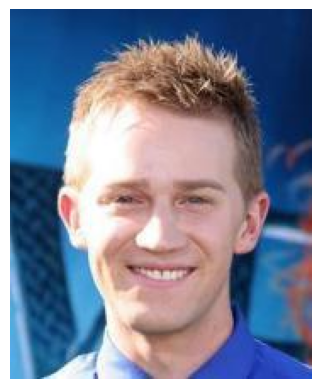

In [5]:
if hasattr(img, "permute"):
    img = img.permute(1, 2, 0).numpy()

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
image_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])
train_dataset = celebData(
    image_dir="img_align_celeba/img_align_celeba",
    image_transform=image_transform
)

test_dataset = celebData(
    image_dir="test"
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=False)

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128, nc=3):
        super().__init__()

        self.z_dim = z_dim 

        # Input is (batch, z_dim, 1, 1)
        self.g_net = nn.Sequential(
            # (z_dim, 1, 1) → (ngf*8, 4, 4)
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ngf*8, 4, 4) → (ngf*4, 8, 8)
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ngf*4, 8, 8) → (ngf*2, 16, 16)
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ngf*2, 16, 16) → (ngf, 32, 32)
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            # (ngf, 32, 32) → (nc, 64, 64)
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.g_net(z)   # z must be 4D: (batch, z_dim, 1, 1)

In [9]:
# Example usage
z = torch.randn(16, 100, 1, 1)   # (batch=16, z_dim=100, 1, 1)
gen = Generator(z_dim=100)
fake_imgs = gen(z)               # Output: (16, 3, 64, 64)
print(fake_imgs.shape)

torch.Size([16, 3, 64, 64])


In [10]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()

        # Input: (nc, 64, 64)
        self.d_net = nn.Sequential(
            # (nc, 64, 64) → (ndf, 32, 32)
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf, 32, 32) → (ndf*2, 16, 16)
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2, 16, 16) → (ndf*4, 8, 8)
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4, 8, 8) → (ndf*8, 4, 4)
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*8, 4, 4) → (1, 1, 1)
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.d_net(img)
        return out.view(-1, 1)   # Flatten output to (batch, 1)

In [11]:
# Example usage
img = torch.randn(16, 3, 64, 64)   # batch of fake or real images
disc = Discriminator(nc=3, ndf=64)
out = disc(img)                    # Output: (16, 1)
print(out.shape)

torch.Size([16, 1])


In [12]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
gen = Generator(z_dim=100).to(device)
gen.apply(weights_init)

Generator(
  (g_net): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Con

In [15]:
disc = Discriminator().to(device)
disc.apply(weights_init)

Discriminator(
  (d_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [16]:
optimizer_D = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0005, betas=(0.5, 0.999))

In [ ]:
from tqdm.notebook import tqdm
import logging
from datetime import datetime
import torchvision.utils as vutils


# Create logs directory
os.makedirs("logs_gan3", exist_ok=True)

save_dir = 'samples2'
os.makedirs(save_dir, exist_ok=True)

# Timestamped log file
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_file = f"logs_gan/train_{timestamp}.log"


# Configure logging
logging.basicConfig(
    filename=log_file,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Config
epochs = 50
batch_size = 64
checkpoint_path = "best_gan4.pth"
best_loss = float('inf')
patience = 5
patience_counter = 0
z_dim=100
save_checkpoint = True

logging.info(f'''Starting GAN training:
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {0.0002}
    Device:          {device}
    Beta1, Beta2:    (0.5, 0.999)
    Checkpoints:     {save_checkpoint}
''')


# Resume training if checkpoint exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch'] 
    best_loss = checkpoint['loss_G']  # monitor generator loss
    logging.info(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0


fixed_noise = torch.randn(16, gen.z_dim, 1, 1, device=device)

criterion = nn.BCELoss()


for epoch in range(start_epoch, epochs):
    epoch_loss_d = 0.0
    epoch_loss_g = 0.0

    # Wrap train_loader with tqdm
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)
    
    for real_images in loop:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()


        # 🔹 Instance noise
        noise_std = 0.05
        real_noisy = real_images + noise_std * torch.randn_like(real_images)
        real_noisy = torch.clamp(real_noisy, 0.0, 1.0)


        z = torch.randn(batch_size, gen.z_dim, 1, 1, device=device)
        fake_images = gen(z)
        fake_noisy = fake_images.detach() + noise_std * torch.randn_like(fake_images)
        fake_noisy = torch.clamp(fake_noisy, 0.0, 1.0)


        # 🔹 Label smoothing (instead of 1.0 and 0.0)
        real_smooth = 0.9
        fake_smooth = 0.1

        # Real images → y = 1
        real_pred = disc(real_noisy)

        # Real images loss
        # real_loss = -(1*torch.log(real_pred+1e-8) + (1-1)*torch.log(1-real_pred+ 1e-8)).mean()  
        # real_loss = -(real_smooth * torch.log(real_pred + 1e-8) + (1 - real_smooth) * torch.log(1 - real_pred + 1e-8)).mean()
        
        real_labels = torch.full((batch_size, 1), 0.9, device=device)  # label smoothing
        fake_labels = torch.full((batch_size, 1), 0.0, device=device)


        # batch_size = real_images.size(0)
        # z = torch.randn(batch_size, gen.z_dim, device=device)  # [batch, 100]
        # fake_images = gen(z)
        # fake_images_reshaped = fake_images.view(-1, 3, 64, 64)

        # fake_pred = disc(fake_noisy.detach())
        # # fake_loss = -(0*torch.log(fake_pred+1e-8) + (1-0)*torch.log(1-fake_pred+ 1e-8)).mean()
        # fake_loss = -(fake_smooth * torch.log(fake_pred + 1e-8) + (1 - fake_smooth) * torch.log(1 - fake_pred + 1e-8)).mean()


        # d_loss = real_loss + fake_loss

        # Discriminator
        real_pred = disc(real_images)
        d_loss_real = criterion(real_pred, real_labels)
        
        fake_pred = disc(fake_images.detach())
        d_loss_fake = criterion(fake_pred, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # Generator tries to fool discriminator
        z = torch.randn(batch_size, gen.z_dim, 1, 1, device=device)   # new z sample
        fake_images = gen(z)
        # fake_pred = disc(fake_images)
        # g_loss = -(torch.log(fake_pred+ 1e-8)).mean()

        # Generator
        fake_pred = disc(fake_images)
        g_loss = criterion(fake_pred, real_labels)  # try to fool discriminator


        g_loss.backward()
        optimizer_G.step()

        epoch_loss_d = epoch_loss_d + d_loss.item()
        epoch_loss_g = epoch_loss_g + g_loss.item()

        # Update tqdm description with losses
        loop.set_postfix(D_loss=epoch_loss_d/(loop.n+1), G_loss=epoch_loss_g/(loop.n+1))

    avg_loss_d = epoch_loss_d / len(train_loader)
    avg_loss_g = epoch_loss_g / len(train_loader)

    logging.info(f"Epoch {epoch+1}: D Loss: {avg_loss_d:.4f}, G Loss: {avg_loss_g:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, D Loss: {avg_loss_d:.4f}, G Loss: {avg_loss_g:.4f}")

    # save samples every 5 epochs
    if (epoch + 1) % 1 == 0:
        gen.eval()
        with torch.no_grad():
            fake_images = gen(fixed_noise).view(-1, 3, 64, 64)  # (N, 3, 64, 64)
        gen.train()
    
        # Normalize to [0,1] for saving
        fake_images = (fake_images + 1) / 2  # assuming output in [-1,1]
    
        vutils.save_image(fake_images, f"samples2/fake_epoch_{epoch+1}.png",
                          nrow=4, normalize=True)
        logging.info(f"Saved sample images for epoch {epoch+1}")


    # Always save the latest (for resuming)
    if save_checkpoint:
        torch.save({
            'epoch': epoch + 1,
            'gen_state_dict': gen.state_dict(),
            'disc_state_dict': disc.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'loss_G': avg_loss_g,
            'loss_D': avg_loss_d
        }, checkpoint_path)
        logging.info(f"Saved checkpoint at epoch {epoch+1} (G loss {best_loss:.6f})")

    # --------------------------
    # Checkpoint + Early Stopping
    # --------------------------
    # if avg_loss_g < best_loss:  # track generator loss
    #     best_loss = avg_loss_g
    #     patience_counter = 0
    #     logging.info(f"Improved G loss: {best_loss:.6f}")
    # else:
    #     patience_counter += 1
    #     logging.info(f"No improvement in G loss (patience {patience_counter}/{patience})")

    # if patience_counter >= patience:
    #     logging.info(f"Early stopping at epoch {epoch+1}")
    #     print("Early stopping triggered")
    #     break

Epoch [32/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 32/50, D Loss: 0.5487, G Loss: 3.4164


Epoch [33/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 33/50, D Loss: 0.5712, G Loss: 3.0838


Epoch [34/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 34/50, D Loss: 0.5617, G Loss: 3.2569


Epoch [35/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 35/50, D Loss: 0.5511, G Loss: 3.2122


Epoch [36/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 36/50, D Loss: 0.5597, G Loss: 3.1769


Epoch [37/50]:   0%|          | 0/3166 [00:00<?, ?it/s]